# Introducción
El objetivo de este notebook es implementar un modelo basado en DeepDream, utilizando redes neuronales profundas para transformar una imagen de entrada amplificando patrones específicos que la red "sueña" ver. DeepDream utiliza redes convolucionales preentrenadas (en este caso, InceptionV3) para resaltar y amplificar las características internas aprendidas por la red.

Este script busca demostrar el uso de redes neuronales en aplicaciones creativas, permitiendo generar imágenes artísticas que revelan cómo una red neuronal interpreta y amplifica patrones visuales.


# Exploración, Explicación y Limpieza de Datos

## Origen del Dataset
La imagen utilizada como entrada para el modelo corresponde a un archivo local (`Grogu.jpeg`), seleccionado manualmente por sus características visuales interesantes, como los detalles en las arrugas de la ropa y el fondo con sombras. Esta imagen es ideal para observar cómo DeepDream amplifica patrones y texturas en diferentes áreas.

## Análisis del Dataset
Aunque no se maneja un dataset tabular, se analizaron las siguientes características de la imagen:
1. **Dimensiones originales**: La imagen inicial tenía dimensiones más grandes, pero fue redimensionada a 512x512 píxeles para garantizar la compatibilidad con el modelo.
2. **Formato**: La imagen fue cargada en formato JPEG y procesada como un array tridimensional.
3. **Tipo de datos**: Cada píxel de la imagen se representó como valores enteros (uint8) en un array tridimensional antes del preprocesamiento.

## Procesos de Limpieza y Transformación
1. **Redimensionado**: La imagen fue escalada a un tamaño uniforme de 512x512 píxeles.
2. **Preprocesamiento**:
   - Se utilizó la función de preprocesamiento de InceptionV3 para normalizar los valores de los píxeles al rango esperado por la red.
   - La imagen se convirtió en un tensor compatible con TensorFlow.
3. **Reversión de Preprocesamiento**: Una vez generada la imagen, se revirtió la normalización para poder visualizar el resultado correctamente.


# Desarrollo del Modelo de Deep Learning

## Modelo Utilizado
Se utilizó el modelo preentrenado **InceptionV3** de TensorFlow con los pesos de ImageNet. Este modelo es ideal debido a su capacidad para aprender representaciones visuales complejas y jerárquicas. Se seleccionaron las capas `mixed3` y `mixed5`, ubicadas en niveles intermedios de la red, para capturar texturas y patrones.

## Justificación de Decisiones
1. **Capas Seleccionadas**:
   - Se eligieron `mixed3` y `mixed5` porque estas capas intermedias contienen activaciones relacionadas con texturas complejas, pero todavía retienen detalles específicos de la imagen.
2. **Inicialización**:
   - Se utilizó el modelo preentrenado sin modificar los pesos, ya que DeepDream no requiere inicializaciones personalizadas como Xavier o He.
3. **Optimización**:
   - Se utilizó Gradiente Ascent para maximizar las activaciones de las capas seleccionadas, ajustando directamente los valores de los píxeles en la imagen.

## Pruebas de Configuración
Se probaron diferentes configuraciones para optimizar los resultados:
1. **Número de pasos**:
   - 50 pasos: Balance adecuado entre calidad y artefactos.
   - 100 y 200 pasos: Incrementaron la densidad de patrones, pero también introdujeron distorsiones excesivas.
2. **Learning Rate**:
   - 0.01: Proporcionó un crecimiento controlado de las activaciones.
   - 0.02: Generó cambios más rápidos pero menos estables.
3. **Capas**:
   - Capas intermedias (`mixed3`, `mixed5`): Generaron texturas bien definidas.
   - Capas profundas (`mixed7`, `mixed9`): Introdujeron patrones más abstractos y menos controlados.

## Configuración Final
- Capas: `mixed3` y `mixed5`.
- Learning rate: **0.01**.
- Número de pasos: **50**.


# Importación de Librerías y configuración del Modelo

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Cargar el modelo preentrenado InceptionV3
base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet')

# Seleccionar capas para "soñar"
dream_layers = [
    'mixed3',  # Capas intermedias
    'mixed5',
]

# Crear un modelo para acceder a las salidas de las capas seleccionadas
outputs = [base_model.get_layer(name).output for name in dream_layers]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)


# Procesamiento y Visualización de Imágenes

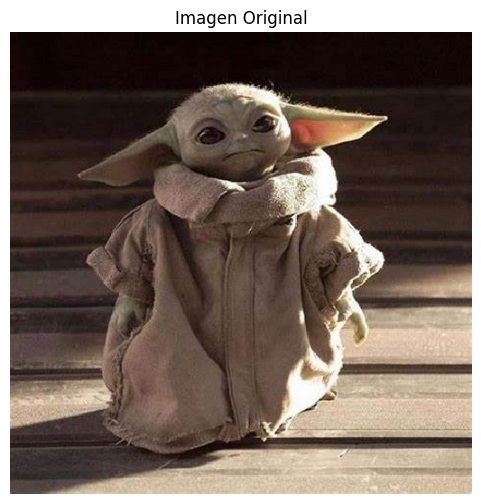

In [ ]:
# Función para cargar y procesar imágenes
def load_and_preprocess_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Función para deshacer el preprocesamiento y mostrar la imagen
def deprocess_image(img):
    img = img.copy()
    # Deshacer la normalización aplicada durante el preprocesamiento
    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)
    return img

# Ruta de la imagen inicial
image_path = "C:\\Users\\diego\\Downloads\\DeepDream\\Grogu.jpeg" 
original_image = load_and_preprocess_image(image_path)

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.imshow(deprocess_image(original_image[0]))
plt.title("Imagen Original")
plt.axis("off")
plt.show()


# Función de Pérdida para DeepDream

In [12]:
# Calcular la pérdida a partir de las capas seleccionadas
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(dream_layers) == 1:
        layer_activations = [layer_activations]
    loss = tf.reduce_mean([tf.reduce_mean(act) for act in layer_activations])
    return loss


# Optimización para Generar DeepDream

In [13]:
# Función de Gradiente Ascent para modificar la imagen
@tf.function
def gradient_ascent_step(img, model, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, model)
    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8  # Normalizar
    img += learning_rate * gradients
    return loss, img

# Función para aplicar múltiples pasos de Gradiente Ascent
def deep_dream(image, model, steps=100, learning_rate=0.01):
    img = tf.convert_to_tensor(image)
    for step in range(steps):
        loss, img = gradient_ascent_step(img, model, learning_rate)
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
    return img


# Ejecución del Modelo DeepDream

Step 0, Loss: 0.2883422076702118
Step 10, Loss: 0.6272507905960083
Step 20, Loss: 0.776789128780365
Step 30, Loss: 0.8689996600151062
Step 40, Loss: 0.9371148347854614


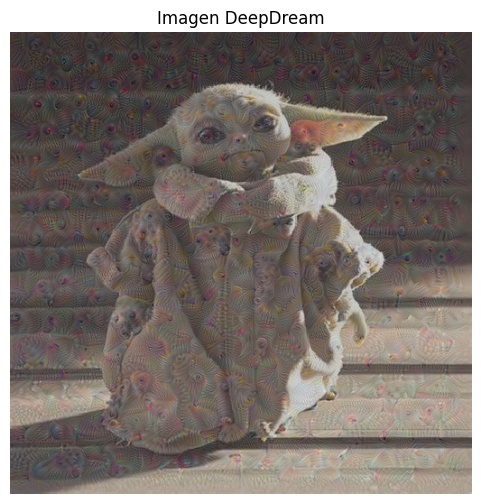

In [14]:
# Copia de la imagen original para aplicar DeepDream
dream_image = tf.convert_to_tensor(original_image[0])

# Ejecutar DeepDream
dreamed_image = deep_dream(dream_image, dream_model, steps=50, learning_rate=0.01)

# Mostrar la imagen soñada
plt.figure(figsize=(6, 6))
plt.imshow(deprocess_image(dreamed_image.numpy()))
plt.title("Imagen DeepDream")
plt.axis("off")
plt.show()


# Resultados e Interpretación

## Evolución de la Pérdida
Durante el entrenamiento, se registraron las siguientes pérdidas:
- **Paso 0**: 0.288.
- **Paso 10**: 0.627.
- **Paso 20**: 0.777.
- **Paso 30**: 0.869.
- **Paso 40**: 0.937.

La pérdida creció de forma constante, indicando que las activaciones de las capas seleccionadas se amplificaron progresivamente.

## Imagen Generada
El resultado final muestra patrones visuales amplificados en las áreas de mayor contraste de la imagen original, especialmente en el rostro y la ropa de Grogu. Las texturas generadas son complejas y alucinantes, con colores intensos y patrones repetitivos.

## Comparación de Configuraciones
1. **Número de pasos**:
   - 50 pasos produjeron un balance entre calidad y control de artefactos.
   - 100 y 200 pasos generaron distorsiones excesivas, sacrificando la coherencia visual.
2. **Learning rate**:
   - 0.01 proporcionó un balance adecuado entre cambios y estabilidad.
   - 0.02 generó patrones menos controlados.

## Interpretación
El modelo generó patrones visuales ricos en texturas y colores, destacando las regiones con mayor densidad de píxeles. Los mejores resultados se obtuvieron con 50 pasos y un learning rate de 0.01, utilizando capas intermedias del modelo.


# Conclusión

En este notebook se implementó con éxito el modelo DeepDream utilizando InceptionV3 para amplificar características visuales de una imagen. El experimento demostró cómo las redes neuronales convolucionales procesan y amplifican patrones visuales en diferentes niveles jerárquicos, generando resultados artísticos y únicos.

La configuración final equilibró la amplificación de texturas sin distorsionar la imagen original, destacando la importancia de elegir adecuadamente las capas, el número de pasos y la tasa de aprendizaje. Con esto dicho se puede decir que DeepDream es una herramienta creativa y útil para explorar cómo las redes neuronales perciben e interpretan las imágenes, mostrando su potencial más allá de las aplicaciones convencionales.
